# Comparing EW and CapWeighted Portfolios

In [2]:
import numpy as np
import pandas as pd

import edhec_risk_kit_204 as erk

%load_ext autoreload
%autoreload 2

ind_cw = erk.get_ind_returns(ew=False)
ind_ew = erk.get_ind_returns(ew=True)

In [3]:
sr = pd.DataFrame({"CW": erk.sharpe_ratio(ind_cw["1945":], 0.03, 12), "EW": erk.sharpe_ratio(ind_ew["1945":], 0.03, 12)})

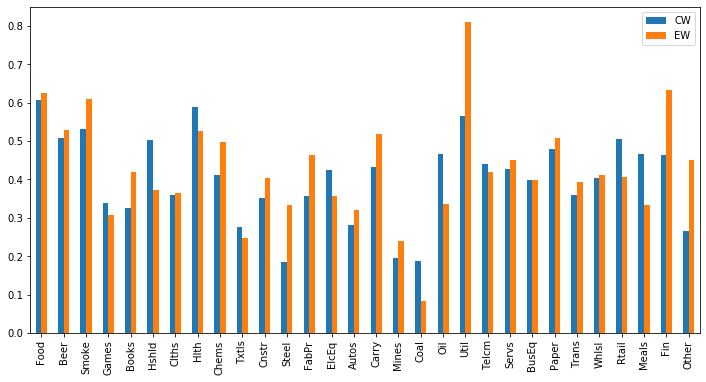

In [4]:
sr.plot.bar(figsize=(12, 6))

In [5]:
(sr["EW"] > sr["CW"]).sum()*100/sr.shape[0]

63.333333333333336

Text(0.5, 1.0, 'Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018')

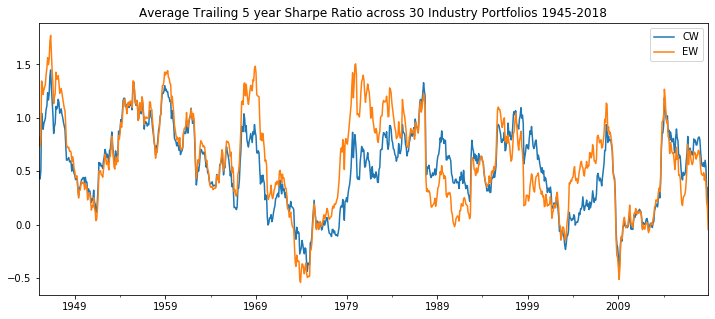

In [6]:
ax = ind_cw.rolling(60).apply(erk.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12}).mean(axis=1)["1945":].plot(figsize=(12,5), label="CW", legend=True)
ind_ew.rolling(60).apply(erk.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12}).mean(axis=1)["1945":].plot(ax=ax, label="EW", legend=True)
ax.set_title("Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018")

```python    
ind49_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

# Backtesting: EW vs CW

In [2]:
def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def backtest_ws(r, estimation_window=60, weighting=weight_ew):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

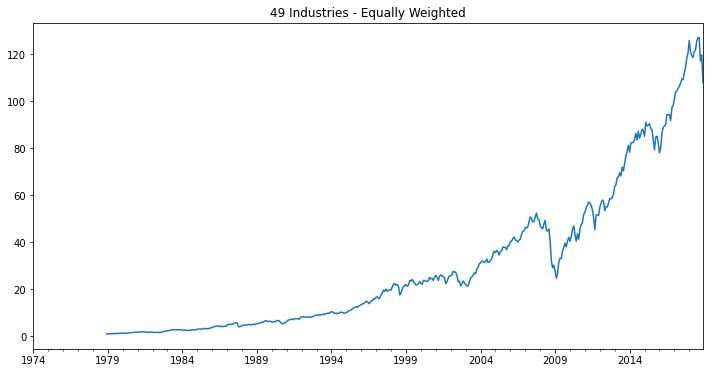

In [3]:
ewr = backtest_ws(ind49_rets, weighting=weight_ew)
ewi = (1+ewr).cumprod()
ewi.plot(figsize=(12,6), title="49 Industries - Equally Weighted");

In [4]:
def weight_ew(r, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    return cap_weights.loc[r.index[1]]

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert list of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


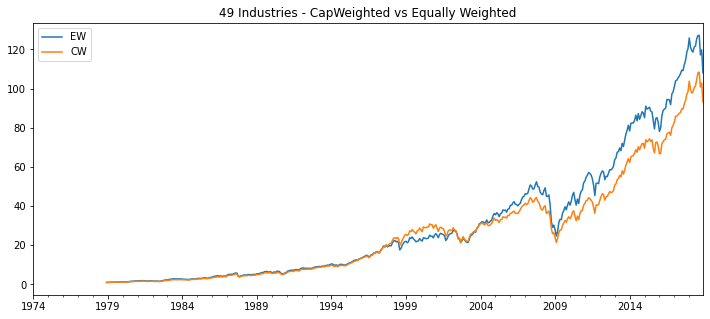

In [5]:
ewr = backtest_ws(ind49_rets)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5), title="49 Industries - CapWeighted vs Equally Weighted")
erk.summary_stats(btr.dropna())

# Improving EW with CapWeight Tethering

Equal Weight portfolios are popular but they'll be constrained in some way - for instance to match the sector weights of the cap-weighted benchmark or to make sure that microcap stocks are not overweighted. The motivation for doing so could be to make a portfolio more tradeable (e.g. some microcaps may not have the liquidity) or to improve the tracking error to the Cap-Weighted index.

That can be achieved by (i) drop microcap stocks beyond a particular threshold, and (ii) impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of the weight it would be in a cap-weighted portfolio.

In [6]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[1]]
    return w/w.sum()

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
EW-Tethered,0.125572,0.156923,-0.752967,6.187433,0.069778,0.099191,0.592597,-0.530654
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


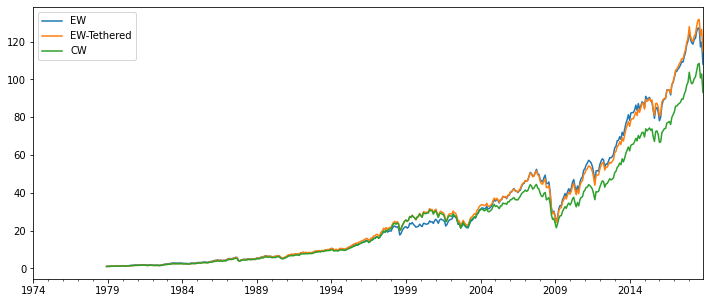

In [7]:
ewr = backtest_ws(ind49_rets)
ewtr = backtest_ws(ind49_rets, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.005)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "EW-Tethered": ewtr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5))
erk.summary_stats(btr.dropna())

In [8]:
erk.tracking_error(ewr, cwr),erk.tracking_error(ewtr, cwr)

(0.23248147494738433, 0.1553623086424526)